In [1]:
import copy, warnings
from oil.tuning.args import argupdated_config
from oil.datasetup.datasets import split_dataset
from oil.tuning.study import train_trial
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from oil.utils.utils import LoaderTo, islice, FixedNumpySeed, cosLr
import biases.datasets as datasets
import biases.dynamicsTrainer as dynamicsTrainer
from biases.datasets import RigidBodyDataset, CartpoleDataset
from biases.dynamicsTrainer import FC,CHFC,CHLC, IntegratedDynamicsTrainer, HNN,LNN
from biases.hamiltonian import ChainPendulum
import lie_conv.lieGroups as lieGroups

def makeTrainer(*,network=HNN,net_cfg={},lr=1e-2,n_train=300,regen=False,
        dataset=RigidBodyDataset,C=5,dt=0.1,dtype=torch.float32,angular=True,
        device=torch.device("cuda"), bs=200,num_epochs=500,trainer_config={}):
    # Create Training set and model
    splits = {"train": n_train, "val": 100, "test": 100}
    dataset = dataset(n_systems=1000, regen=regen, chunk_len=C,body=ChainPendulum(1),
                     dt=dt, integration_time=10,angular_coords=angular)
    #dataset=CartpoleDataset(batch_size=500,regen=regen)
    with FixedNumpySeed(0):
        datasets = split_dataset(dataset, splits)
    model = network(G=dataset.body.body_graph,angular_dims=angular,**net_cfg).to(device=device, dtype=dtype)

    # Create train and Dev(Test) dataloaders and move elems to gpu
    dataloaders = {k: LoaderTo(
                DataLoader(v, batch_size=min(bs, splits[k]), num_workers=0, shuffle=(k == "train")),
                device=device,dtype=dtype) for k, v in datasets.items()}
    dataloaders["Train"] = dataloaders["train"]
    # Initialize optimizer and learning rate schedule
    opt_constr = lambda params: Adam(params, lr=lr)
    lr_sched = cosLr(num_epochs)
    return IntegratedDynamicsTrainer(model,dataloaders,opt_constr,lr_sched,
                                     log_args={"timeFrac": 1 / 4, "minPeriod": 0.0},**trainer_config)


In [2]:
trainer = makeTrainer(dt=.1,C=5,regen=False,lr=3e-3,angular=True)

tensor(0.0003, dtype=torch.float64)


In [3]:
trainer.train(500)

/home/marc_f/anaconda3/envs/default/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


   Minibatch_Loss  Train_MSE    lr0  nfe  test_MSE   val_MSE
0        0.035912   0.036767  0.003  0.0  0.026544  0.029062
    Minibatch_Loss  Train_MSE       lr0   nfe  test_MSE   val_MSE
17        0.048539   0.059849  0.002998  32.0  0.043855  0.053036
    Minibatch_Loss  Train_MSE       lr0   nfe  test_MSE   val_MSE
32        0.017902   0.032769  0.002993  32.0  0.018198  0.012832
    Minibatch_Loss  Train_MSE       lr0   nfe  test_MSE   val_MSE
48        0.011773   0.010638  0.002984  32.0   0.00959  0.008989
    Minibatch_Loss  Train_MSE       lr0   nfe  test_MSE   val_MSE
63        0.004136   0.005203  0.002972  32.0  0.004223  0.004555
    Minibatch_Loss  Train_MSE       lr0   nfe  test_MSE   val_MSE
77         0.00346    0.00316  0.002957  32.0  0.003303  0.003397
    Minibatch_Loss  Train_MSE      lr0   nfe  test_MSE   val_MSE
91        0.002163    0.00228  0.00294  32.0  0.002662  0.002817
     Minibatch_Loss  Train_MSE       lr0   nfe  test_MSE   val_MSE
105        0.001531  

     Minibatch_Loss  Train_MSE       lr0   nfe  test_MSE   val_MSE
880        0.000066   0.000048  0.000107  32.0  0.000059  0.000033
     Minibatch_Loss  Train_MSE       lr0   nfe  test_MSE   val_MSE
894        0.000062   0.000053  0.000084  32.0  0.000058  0.000033
     Minibatch_Loss  Train_MSE       lr0   nfe  test_MSE   val_MSE
909        0.000094   0.000049  0.000062  32.0  0.000059  0.000033
     Minibatch_Loss  Train_MSE       lr0   nfe  test_MSE   val_MSE
923        0.000045   0.000061  0.000045  32.0  0.000058  0.000033
     Minibatch_Loss  Train_MSE      lr0   nfe  test_MSE   val_MSE
937        0.000029   0.000053  0.00003  32.0  0.000058  0.000033
     Minibatch_Loss  Train_MSE       lr0   nfe  test_MSE   val_MSE
951        0.000078   0.000054  0.000018  32.0  0.000058  0.000032
     Minibatch_Loss  Train_MSE      lr0   nfe  test_MSE   val_MSE
965        0.000103   0.000057  0.00001  32.0  0.000058  0.000033
     Minibatch_Loss  Train_MSE       lr0   nfe  test_MSE   val_MSE

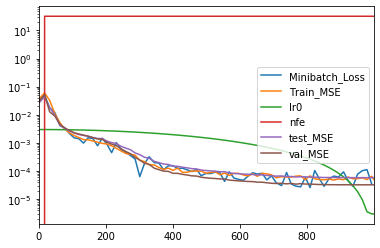

In [4]:
trainer.logger.scalar_frame.plot()
import matplotlib.pyplot as plt
plt.yscale('log')

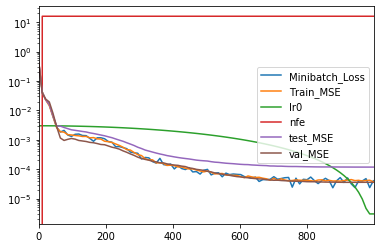

In [6]:
trainer.logger.scalar_frame.plot()
import matplotlib.pyplot as plt
plt.yscale('log')

In [39]:
#trainer.dataloaders['train'].dataset[0]

In [21]:
i=10
z0 = trainer.dataloaders['train'].dataset[i][0][0].unsqueeze(0)
T = trainer.dataloaders['train'].dataset[i][0][1]
T = torch.linspace(0,5,50).cuda()
#trainer.model._m_lower = trainer.model._m_lower.to(device=torch.device("cuda"))
zt = trainer.model.integrate(z0.float().cuda(),T.float().cuda())

In [22]:
trainer.dataloaders['train'].dataset[i][1][:,0,0]

tensor([[ 0.0000e+00,  1.0000e+00],
        [ 4.9544e-02,  1.0000e+00],
        [ 9.0886e-02,  1.0000e+00],
        [ 3.3339e-02,  1.0000e+00],
        [-1.8710e-05,  1.0000e+00]], dtype=torch.float64)

In [23]:
z0[0,0,1]

tensor([0.5000, 1.0000], dtype=torch.float64)

In [24]:
zt[0,:,0,0]

tensor([[ 0.0000e+00,  1.0000e+00],
        [-8.1722e-05,  1.0000e+00],
        [-3.2688e-04,  1.0000e+00],
        [-7.3546e-04,  1.0000e+00],
        [-1.3074e-03,  1.0000e+00],
        [-2.0427e-03,  1.0000e+00],
        [-2.9413e-03,  1.0000e+00],
        [-4.0030e-03,  1.0000e+00],
        [-5.2279e-03,  1.0000e+00],
        [-6.6157e-03,  1.0000e+00],
        [-8.1665e-03,  1.0000e+00],
        [-9.8799e-03,  1.0000e+00],
        [-1.1756e-02,  1.0000e+00],
        [-1.3795e-02,  1.0000e+00],
        [-1.5995e-02,  1.0000e+00],
        [-1.8358e-02,  1.0000e+00],
        [-2.0883e-02,  1.0000e+00],
        [-2.3569e-02,  1.0000e+00],
        [-2.6417e-02,  1.0000e+00],
        [-2.9426e-02,  1.0000e+00],
        [-3.2597e-02,  1.0000e+00],
        [-3.5927e-02,  1.0000e+00],
        [-3.9418e-02,  1.0000e+00],
        [-4.3070e-02,  1.0000e+00],
        [-4.6881e-02,  1.0000e+00],
        [-5.0851e-02,  1.0000e+00],
        [-5.4981e-02,  1.0000e+00],
        [-5.9270e-02,  1.000

In [21]:
from biases.hamiltonian import ChainPendulum, Animation2d, MLE,MLE2
from IPython.display import HTML
import matplotlib.pyplot as plt

In [12]:
P = ChainPendulum(2)
z0s = P.sample_initial_conditions(1).double()
ts = torch.linspace(0,10,500).double()
zt = P.integrate(z0s,ts,tol=1e-6).cuda()
zt_p = P.integrate((z0s+1e-4*torch.randn_like(z0s)),ts,tol=1e-6).cuda()
z0 = z0s.cuda()

In [13]:
with torch.no_grad():
    trainer.model.float()#.double()#.float()#double()
    z_hat_t = trainer.model.integrate(z0.float(),ts.float()).double()

In [14]:
xt = zt[0,:,0,:].permute(1,2,0).cpu()
xt_hat = z_hat_t[0,:,0,:].permute(1,2,0).cpu()
xt_p = zt_p[0,:,0,:].permute(1,2,0).cpu()

In [15]:
err = ((xt-xt_hat)**2).sum(1).sum(0).sqrt()/((xt+xt_hat)**2).sum(1).sum(0).sqrt()
err2 = ((xt-xt_p)**2).sum(1).sum(0).sqrt()/((xt+xt_p)**2).sum(1).sum(0).sqrt()

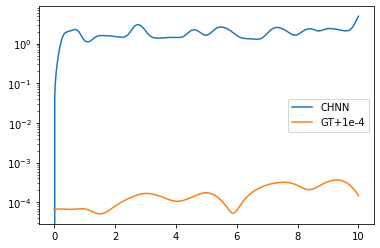

In [16]:
plt.plot(ts,err)
plt.plot(ts,err2)
plt.yscale('log')
plt.legend(['CHNN','GT+1e-4'])

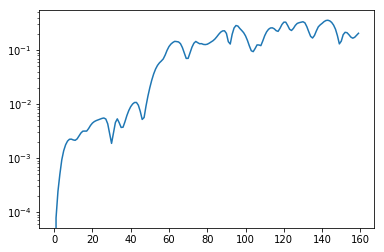

In [42]:
plt.plot(err)
plt.yscale('log')

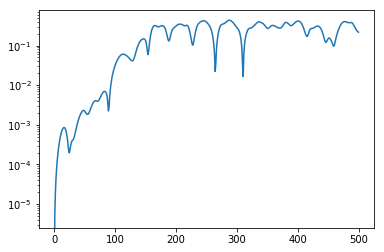

In [39]:
plt.plot(err)
plt.yscale('log')

In [31]:
P.Minv

tensor([[1., 0., -0.],
        [0., 1., -0.],
        [0., 0., 1.]])

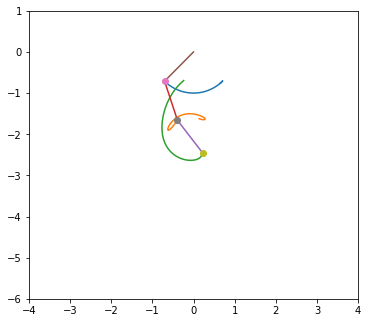

In [66]:
HTML(Animation2d(xt.float(),P,box_lim=(-4,4,-6,1)).animate().to_html5_video())

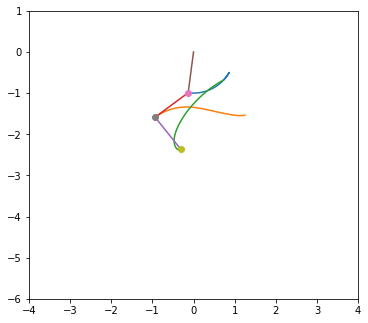

In [67]:
HTML(Animation2d(xt_hat.float(),P,box_lim=(-4,4,-6,1)).animate().to_html5_video())

In [ ]:
P = ChainPendulum(3)
z0s = P.sample_initial_conditions(1).double()
bs = z0.shape[0]
xp = torch.stack([z0s[:,0],P.M@z0s[:,1]],dim=1).reshape(bs,-1)
ts = torch.linspace(0,1000,100).double()
es = MLE2(xp,P.dynamics(wgrad=True),ts,rtol=1e-4)
plt.plot(es[1:,0,-1]/ts[1:])

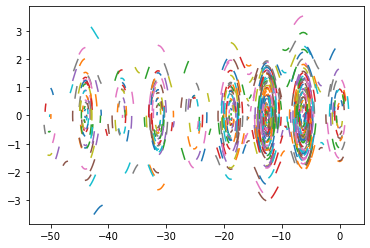

In [5]:
#ds = RigidBodyDataset(n_systems=1000,body=ChainPendulum(1),angular_coords=True,regen=True)
import matplotlib.pyplot as plt
ds = trainer.dataloaders['train'].dataset
plt.plot(ds.Zs[:,:,0,0,0].T,ds.Zs[:,:,1,0,0].T)
#plt.scatter(*ds.Zs[50,:,0,0,0].T)